
ARIMA-TimeSeries Analysis of Tractor Sales

Pythonification and enhancement of Roopam Upadhyaya's blog on Time Series Analysis http://ucanalytics.com/blogs/step-by-step-graphic-guide-to-forecasting-through-arima-modeling-in-r-manufacturing-case-study-example/ in R.

In this case study example, we will learn about time series analysis for a manufacturing operation. Time series analysis and modeling have many business and social applications. It is extensively used to forecast company sales, product demand, stock market trends, agricultural production etc.

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

    Trend – overall direction of the series i.e. upwards, downwards etc.
    Seasonality – monthly or quarterly patterns
    Cycle – long-term business cycles, they usually come after 5 or 7 years
    Irregular remainder – random noise left after extraction of all the components

Interference of these components produces the final series.

Why bother decomposing the original / actual time series into components? It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.
Step 0: Problem Definition

PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it’s inventory and production cost down because of variability in sales and tractor demand. The management at PowerHorse is under enormous pressure from the shareholders and board to reduce the production cost. Additionally, they are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have hired us as a data science and predictive analytics consultant.

We will develop an ARIMA model to forecast sale / demand of tractor for next 3 years. Additionally, We will also investigate the impact of marketing program on sales by using an exogenous variable ARIMA model.

As a part of this project, one of the production units we are analysing is based in South East Asia. This unit is completely independent and caters to neighbouring geographies. This unit is just a decade and a half old. In 2014 , they captured 11% of the market share, a 14% increase from the previous year. However, being a new unit they have very little bargaining power with their suppliers to implement Just-in-Time (JiT) manufacturing principles that have worked really well in PowerHorse’s base location. Hence, they want to be on top of their production planning to maintain healthy business margins. Monthly sales forecast is the first step we have suggested to this unit towards effective inventory management.

The MIS team shared the month on month (MoM) sales figures (number of tractors sold) for the last 12 years in the tractor-sales.csv file.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

# Step 1: Visualize Tractor Sales data as time series

In [3]:
from io import StringIO
import requests

url = 'http://www.ucanalytics.com/blogs/wp-content/uploads/2015/06/Tractor-Sales.csv'
s = requests.get(url).text

sales_data = pd.read_csv(StringIO(s))
sales_data.head(5)

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [4]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [7]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [9]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [11]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [13]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

Text(0,0.5,u'Tractor Sales')

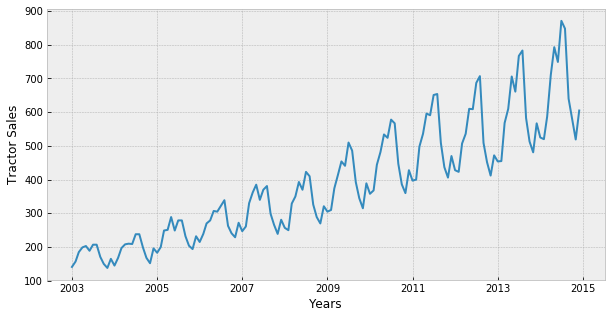

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Now we start with time series decomposition of this data to understand underlying patterns such as trend, seasonality, cycle and irregular remainder for tractor sales.

In the above data, a cyclic pattern seems to be non-existent since the unit we are analysing is a relatively new unit to notice business cycles. Also in theory, business cycles in traditional businesses are observed over a period of 7 or more years. Hence, we won’t include business cycles in this time series decomposition exercise. Also, we observe a overall increasing trend across years. We will build our model based on the following function:
Yt=f(Trendt,Seasonalityt,Remaindert)

Step 1.1: Trend - Time Series Decomposition

Now, to begin with let's try to decipher trends embedded in the above tractor sales time series. It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following:

    Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

    Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

Moving Average - A good analogy for moving average is ironing clothes to remove wrinkles. The idea with moving average is to remove all the zigzag motion (wrinkles) from the time series to produce a steady trend through averaging adjacent values of a time period. Hence, the formula for moving average is:
MovingAverage=∑mi=−mYt+i2m

Now, let’s try to remove wrinkles from our time series using moving average. We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below. Here, moving average is shown in red and actual series in blue.

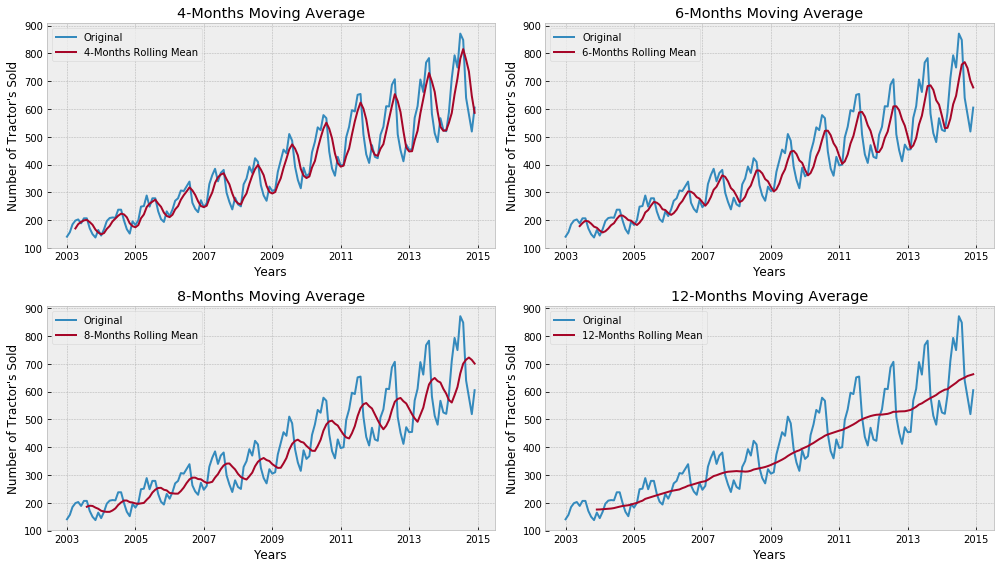

In [19]:


fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()





As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.


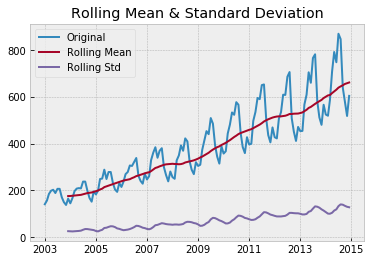

In [18]:
#Determing rolling statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


In [20]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (5%)             -2.884219
Critical Value (1%)             -3.482088
Critical Value (10%)            -2.578864
dtype: float64




Though the variation in standard deviation is small, rolling mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

As we observed while plotting the moving average over months that there is a monhly pattern, now, let’s decipher the seasonal component.

Step 1.2: Seasonality – Time Series Decomposition

The first thing to do is to see how number of tractors sold vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data.


In [22]:
monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


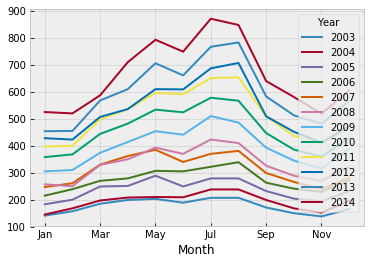

In [24]:
monthly_sales_data.plot()

In [25]:
yearly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


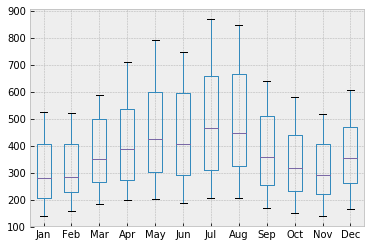

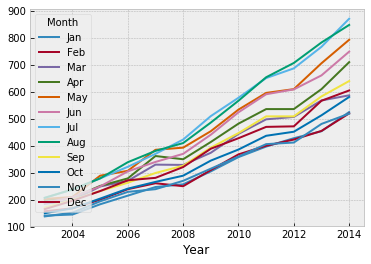

In [28]:
yearly_sales_data.boxplot()
yearly_sales_data.plot()

In [29]:


# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [30]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]